# Лабораторная работа №2
Гетероскедастичность (непостоянство дисперсий регрессионных остатков) часто возникает в случае «неоднородности» объектов наблюдения.

В ходе лабораторной работы необходимо:
1. построить МНК-оценки коэффициентов линейной модели множественной регрессии;
2. исследовать регрессионные остатки на гетероскедастичность, используя тесты Спирмена, Голдфелда-Квандта, Глейзера;
3. если возможно построить ОМНК-оценки параметров регрессионной модели;
4. исследовать линейную модели множественной регрессии с помощью несмещенных оценок ковариационной матрицы вектора оценок.

Подключение библиотек:

In [ ]:
import xlrd
import numpy as np
import pandas as pd
import pylab
import statsmodels.regression.linear_model as s
import scipy, scipy.stats
from statsmodels.stats.api import het_goldfeldquandt
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from numpy import arange
from scipy.stats import f
from statsmodels.compat import lzip

Выгрузка данных:

In [ ]:
"""
загружаем excel-файл, содержащий столбец Y и столбцы X,
оставшиеся после устранения мультиколлинеарности по итогам выполнения первой лабораторной работы.
заголовков столбцов быть не должно
"""
"""ОБЯЗАТЕЛЬНО РАСШИРЕНИЕ У ФАЙЛА xls"""

data = xlrd.open_workbook('table_getero.xls') #УКАЗАТЬ ПУТЬ К ФАЙЛУ
sheet = data.sheet_by_index(0)
vals = [sheet.row_values(rownum) for rownum in range(sheet.nrows)]
vals = np.array(vals)
Y = np.copy(vals[:,:1])
X = np.copy(vals[:,1:])
n, k = X.shape
X = np.hstack([np.ones((X.shape[0], 1)), X])

Построение регрессионной модели по переменным, оставшимся после устранения мультколлинеарности:

In [ ]:
OLS_model = s.OLS(Y,X).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     36.81
Date:                Fri, 13 May 2022   Prob (F-statistic):           2.69e-19
Time:                        13:50:23   Log-Likelihood:                -146.68
No. Observations:                  85   AIC:                             305.4
Df Residuals:                      79   BIC:                             320.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.8818      1.269     55.086      0.000      67.357      72.407
x1             0.2889      0.072      4.025      0.000       0.146       0.432
x2            -0.4986      0.194     -2.564      0.012      -0.886      -0.112
x3            -0.4982      0.140     -3.555      0.001      -0.777      -0.219
x4             0.5481      0.309      1.771      0.080      -0.068       1.164
x5            -1.0019      0.161     -6.213      0.000      -1.323      -0.681
==============================================================================
Omnibus:                        4.190   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.548
Skew:                           0.364   Prob(JB):                        0.170
Kurtosis:                       3.688   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Вычисление регрессионных остатков:

In [ ]:
E = OLS_model.resid

Построим гистограмму распределения регрессионных остатков и проверим гипотезу об их нормальном распределении:

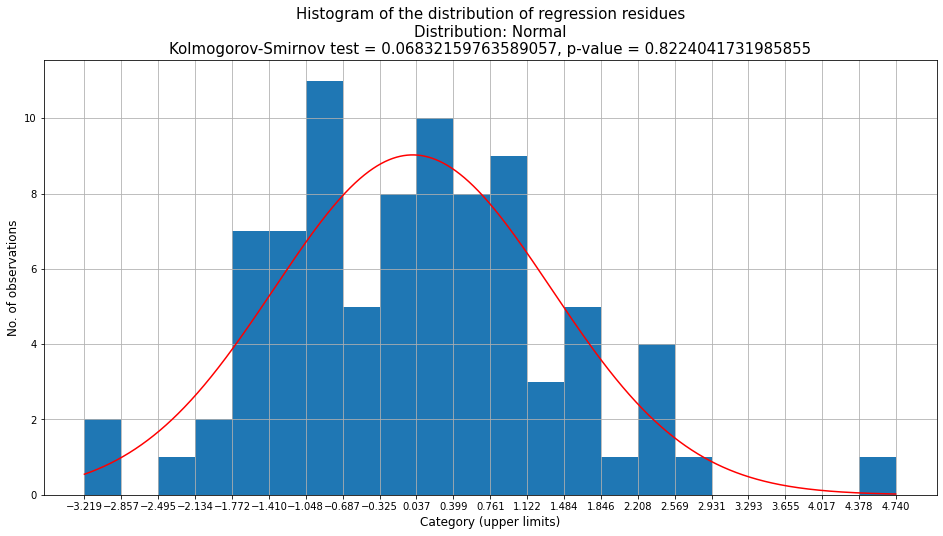

In [ ]:
plt.figure(figsize=(16, 8))
histData = plt.hist(E, bins=22)
range_ = arange(min(E), max(E), 0.005)
coefY = len(E) * (histData[1][1] - histData[1][0])
plt.plot(range_,
         [norm(E.mean(),E.std()).pdf(x) * coefY for x in range_],
         color='r')
plt.xticks(histData[1])
KS_maxD, KS_PValue = kstest(E, cdf='norm', args=(E.mean(), E.std()))
plt.title("Histogram of the distribution of regression residues\n" +
          "Distribution: Normal\n" +
          f"Kolmogorov-Smirnov test = {KS_maxD}, p-value = {KS_PValue}", fontsize=15)
plt.ylabel("No. of observations", fontsize=12)
plt.xlabel("Category (upper limits)", fontsize=12)
plt.grid()
plt.show()

<h4>Анализ графиков остатков</h4>

y = 0.009951x + (0.666084)
y = -0.004181x + (1.259594)
y = -0.005986x + (1.335408)
y = -0.004487x + (1.272468)
y = -0.004562x + (1.275610)


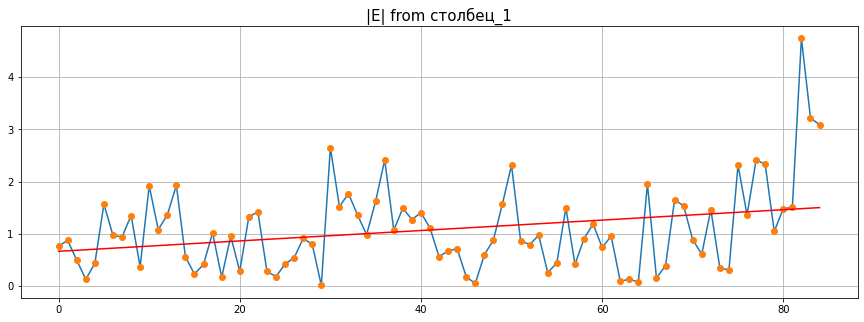

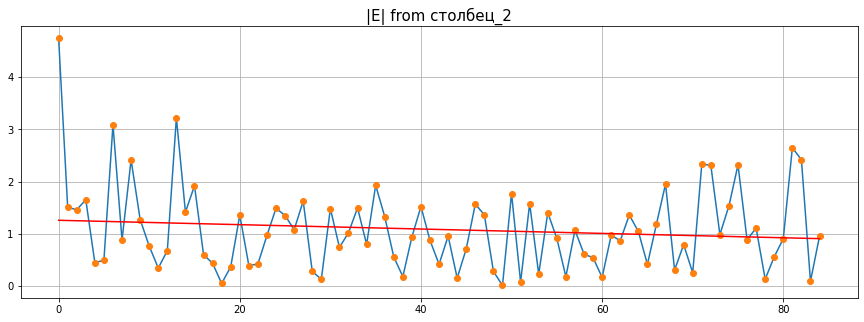

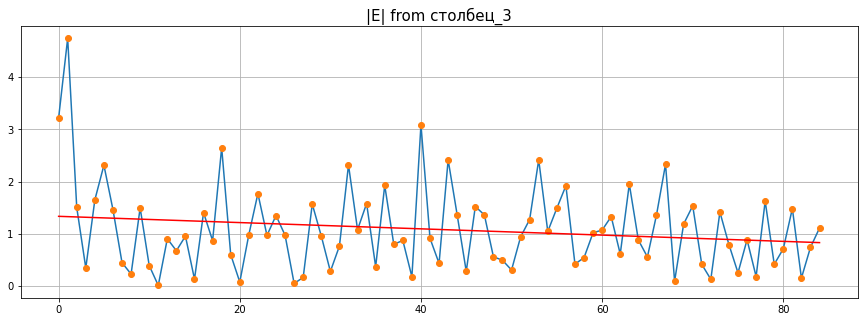

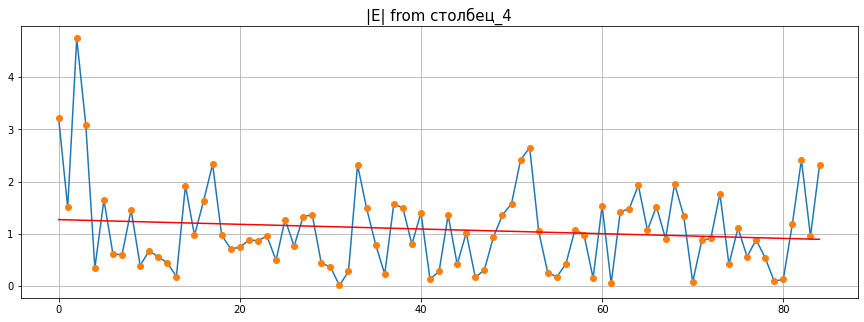

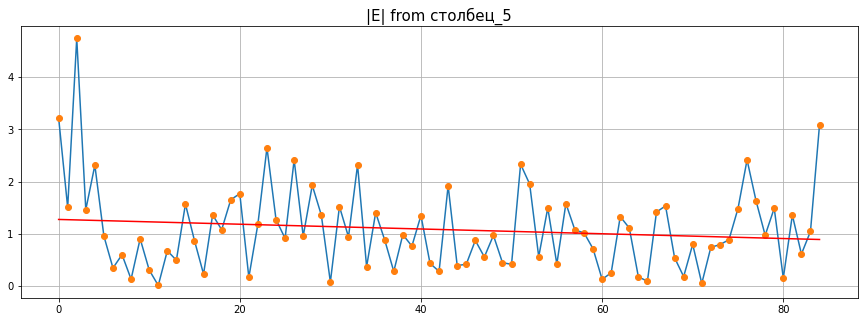

In [ ]:
#Сортировка и график модулей остатков с трендами
maxz = 0
for var in range(1, k+1):
    Xsort = np.copy(X[:, var])
    Epl = abs(E[Xsort.argsort()])
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.title(f"|E| from столбец_{var}", fontsize=15)
    plt.plot(Epl)
    Xgraph = [i for i in range(85)]
    pylab.plot(Xgraph, Epl, 'o')
    z = np.polyfit(Xgraph, Epl, 1)
    p = np.poly1d(z)
    pylab.plot(Xgraph,p(Xgraph), "r-")
    print (f"y = {z[0]:6f}x + ({z[1]:6f})") #z[0] и z[1] - значения b1 и b0 для линии тренда соответственно
# здесь нам нужно увидеть, увеличивается или уменьшается модуль остатков при росте Х, поэтому формат оси Х не важен
    if abs(z[0]) > maxz:
      maxz = z[0]; #определение наибольшего наклона по всем уравнениям тренда
      maxk = var; #номер столбца, по которому дальше исследуем

In [ ]:
print(f"Далее исследоваться гетероскедастичность будет по столбцу {maxk}")

Далее исследоваться гетероскедастичность будет по столбцу 1


<h4>Тест ранговой корреляции Спирмена</h4>


In [ ]:
if maxk == 1:
  X_investigated = X[:,1]
else:
  X_investigated = X[:,maxk:maxk+1]

rho, pval = scipy.stats.spearmanr(E, X_investigated)
Spearman = 0
if pval < 0.05 :
  Spearman = 1; #есть гетеро

scipy.stats.spearmanr(E, X_investigated)

SpearmanrResult(correlation=0.11443737687184957, pvalue=0.2970087077024612)

Т.к. p-value>0.05, то гипотеза об отсутствии гетероскедастичности принимается.

<h4>Тест Голдфелда-Квандта</h4>

In [ ]:
def het_gq(y, x):
    nobs, nvar = x.shape
    sizeSubsample = round(3 * nobs / 8)
    fval, _, _ = het_goldfeldquandt(y=y, x=x, idx=1, split=sizeSubsample, drop=nobs - 2 * sizeSubsample)
    fval_real = fval
    if fval < 1.0:
      fval = 1.0 / fval
      GK = 0 #обратная пропорциональность
    else:
      GK = 1 #прямая пропорциальность
    return (fval, f.ppf(q=0.95, dfn=sizeSubsample - nvar, dfd=sizeSubsample - nvar), GK)


In [ ]:
name = ['F statistic', 'F crit']
GK_Fstat, GK_Fcrit, GK = het_gq(y=Y, x=X[:,[0,maxk]]) # для вычисления сигма-матрицы
if GK_Fstat > GK_Fcrit :
  Test_GK = 1 #тест выполняется

lzip(name, het_gq(y=Y, x=X[:,[0,maxk]]))

[('F statistic', 7.358674460170246), ('F crit', 1.840871689111757)]

Т.к. Fнабл>Fкрит, то гипотеза об отсутствии гетероскедастичности отклоняется.

<h4>Тест Глейзера</h4>

In [ ]:
Xgm = np.zeros((n,13))
gamma = -3
for j in range(0, 13):
    for i in range(0, n):
        Xgm[i][j] = abs(X[i][maxk])**gamma
    gamma = gamma + 0.5
Xgm = np.hstack([np.ones((Xgm.shape[0], 1)), Xgm])
Xgmd = pd.DataFrame(data=Xgm)
Xgmd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,0.001572,0.004611,0.013521,0.039651,0.116279,0.340997,1.0,2.932576,8.6,25.220151,73.96,216.893296,636.056
1,1.0,0.001031,0.003243,0.010203,0.032103,0.101010,0.317821,1.0,3.146427,9.9,31.149623,98.01,308.381266,970.299
2,1.0,0.001687,0.004890,0.014172,0.041075,0.119048,0.345033,1.0,2.898275,8.4,24.345513,70.56,204.502309,592.704
3,1.0,0.000772,0.002549,0.008417,0.027788,0.091743,0.302891,1.0,3.301515,10.9,35.986511,118.81,392.252974,1295.029
4,1.0,0.001953,0.005524,0.015625,0.044194,0.125000,0.353553,1.0,2.828427,8.0,22.627417,64.00,181.019336,512.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1.0,0.000125,0.000559,0.002500,0.011180,0.050000,0.223607,1.0,4.472136,20.0,89.442719,400.00,1788.854382,8000.000
81,1.0,0.001243,0.003791,0.011562,0.035259,0.107527,0.327913,1.0,3.049590,9.3,28.361188,86.49,263.759051,804.357
82,1.0,0.000772,0.002549,0.008417,0.027788,0.091743,0.302891,1.0,3.301515,10.9,35.986511,118.81,392.252974,1295.029
83,1.0,0.000466,0.001673,0.006009,0.021583,0.077519,0.278423,1.0,3.591657,12.9,46.332375,166.41,597.687641,2146.689


Строим уравнения регрессии, выбираем среди ВСЕХ (значимых) уравнений с наибольшим значением коэффициента детерминации:

In [ ]:
Rsqrd = np.zeros((13,6))
u = 0
gamma = -3
for i in range(1,14):
    Rsqrd[u][0] = gamma
    result = s.OLS(abs(E), Xgm[:, [0, i]]).fit()
    Rsqrd[u][1] = result.params[0]
    Rsqrd[u][2] = result.params[1]
    Rsqrd[u][3] = result.fvalue
    Rsqrd[u][4] = result.f_pvalue
    Rsqrd[u][5] = result.rsquared
    u += 1 # u нужно для того, чтобы идти по строкам при составлении таблицы в отчете
    gamma += 0.5

d = {"gamma": Rsqrd[::,0], "b0": Rsqrd[::,1], "b1": Rsqrd[::,2], "F-stat": Rsqrd[::,3], "p-value": Rsqrd[::,4], "R^2": Rsqrd[::,5]}
df = pd.DataFrame(data=d)
df


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


,gamma,b0,b1,F-stat,p-value,R^2
0,-3.0,1.591719,-388.969747,9.142126,3.322779e-03,9.921766e-02
1,-2.5,1.720438,-164.281703,10.563693,1.666833e-03,1.129038e-01
2,-2.0,1.913169,-71.633172,12.299332,7.340316e-04,1.290600e-01
3,-1.5,2.231060,-32.925706,14.399761,2.799613e-04,1.478419e-01
4,-1.0,2.855991,-16.765556,16.900683,9.210943e-05,1.691749e-01
5,-0.5,4.694678,-11.161217,19.800702,2.650641e-05,1.926125e-01
6,0.0,0.542006,0.542006,-inf,NaN,-4.440892e-16
7,0.5,-2.493055,1.144391,26.425279,1.791393e-06,2.414915e-01
8,1.0,-0.644907,0.174742,29.711795,5.039035e-07,2.636086e-01
9,1.5,-0.006801,0.034334,32.551231,1.740213e-07,2.817039e-01


In [ ]:
Fcr = f.ppf(q = 1 - 0.05, dfn = 1, dfd = 85 - 1 - 1)
print("Fcrit = ", Fcr )
umax = 0
Gleyser = 0;
for u in range(0, 13): # цикл для выявления значимости уравнения
    if Rsqrd[u][3] > Fcr:
        print("Уравнение с гамма = ", Rsqrd[u][0], "значимо")
        Gleyser = 1; #значит, что Глейзер выполнился
    else: print("Уравнение с гамма = ", Rsqrd[u][0], "не значимо")

Fcrit =  3.9559610071544236
Уравнение с гамма =  -3.0 значимо
Уравнение с гамма =  -2.5 значимо
Уравнение с гамма =  -2.0 значимо
Уравнение с гамма =  -1.5 значимо
Уравнение с гамма =  -1.0 значимо
Уравнение с гамма =  -0.5 значимо
Уравнение с гамма =  0.0 не значимо
Уравнение с гамма =  0.5 значимо
Уравнение с гамма =  1.0 значимо
Уравнение с гамма =  1.5 значимо
Уравнение с гамма =  2.0 значимо
Уравнение с гамма =  2.5 значимо
Уравнение с гамма =  3.0 значимо


In [ ]:
Rmax = 0
umax = 0
for u in range(0, 13): # цикл для выявления максимального R^2
    if Rsqrd[u][5] > Rmax:
        Rmax = Rsqrd[u][5]
        umax = u
d = {"gamma": Rsqrd[umax][0], "b0": Rsqrd[umax][1], "b1": Rsqrd[umax][2], "F-stat": Rsqrd[umax][3], "p-value": Rsqrd[umax][4], "R^2": Rsqrd[umax][5]}
df = pd.DataFrame(data=d, index = [0])
df

,gamma,b0,b1,F-stat,p-value,R^2
0,3.0,0.667497,0.000356,35.925467,5.102161e-08,0.302084


Строим сигма-матрицу для оценки вектора коэффициентов регрессионной модели:

In [ ]:

Sigm = np.zeros((n,n)) # матрица n x n, заполненная нулями

if Gleyser == 1 :
    for i in range(0, n):
        for j in range(0, n):
            if i==j :
                Sigm[i][j]= (Rsqrd[umax][3] + Rsqrd[umax][4]*X[i][maxk]**Rsqrd[umax][0])**2

elif Spearman == 1:
    if (rho >= 0):
        for i in range(0, n):
            for j in range(0, n):
                if i==j :
                    Sigm[i][j]= (X[i][maxk])**2
    else:
        for i in range(0, n):
            for j in range(0, n):
                if i==j :
                    Sigm[i][j]= 1/((X[i][maxk])**2)

elif Test_GK == 1:
  if (GK == 1):
        for i in range(0, n):
            for j in range(0, n):
                if i==j :
                    Sigm[i][j]= (X[i][maxk])**2
  else:
    for i in range(0, n):
        for j in range(0, n):
            if i==j :
                Sigm[i][j]= 1/((X[i][maxk])**2)
print(Sigm)

[[1290.6414801     0.            0.         ...    0.
     0.            0.        ]
 [   0.         1290.64270542    0.         ...    0.
     0.            0.        ]
 [   0.            0.         1290.64132118 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... 1290.64389587
     0.            0.        ]
 [   0.            0.            0.         ...    0.
  1290.64701802    0.        ]
 [   0.            0.            0.         ...    0.
     0.         1290.64139971]]


Вычисляем Вомнк путем последовательных матричных операций, стандартные ошибки коэффициентов и стандартную ошибку уравнения регрессии:

In [ ]:
Xt = X.T #транспонированная матрица Х
Sigm_inv = np.linalg.inv(Sigm) #обратная к сигма-матрице
XtSinv = np.dot(Xt,Sigm_inv) #их произведение,
XtSinvY = np.dot(XtSinv,Y) #домноженное на Y
XtSinvXinv = np.linalg.inv(np.dot(XtSinv, X))#обратная к произведению
Bomnk = np.dot(XtSinvXinv, XtSinvY)

S = ((Y-X.dot(Bomnk)).T.dot(Sigm_inv).dot(Y-X.dot(Bomnk)))*(1/(n-k-1)) #матрица стандартных ошибок
Eb = S*np.linalg.inv(np.dot(X.T,Sigm_inv).dot(X)) #ковариационная матрица для bомнк

d = {"coef": [i for i in range(k + 1)], "value": Bomnk[:,0], "Std": np.sqrt(np.diagonal(Eb))}
df = pd.DataFrame(data=d)
print('Стандартная ошибка:', *S)
df

Стандартная ошибка: [0.00153963]


,coef,value,Std
0,0,69.881812,1.268601
1,1,0.288933,0.071781
2,2,-0.498585,0.194445
3,3,-0.498244,0.140136
4,4,0.548135,0.309486
5,5,-1.001928,0.161270
